# This notebook demostrates how to train a GPR model with Gpy.
# Before runing this notebook, please install Gpy with the following command:

With anaconda you can install GPy by the following:

conda update scipy

Then potentially try,

sudo apt-get update
sudo apt-get install python3-dev
sudo apt-get install build-essential   
conda update anaconda

And finally,

pip install gpy

We've also had luck with enthought. Install scipy 1.3.0 (or later) and then pip install GPy:

pip install gpy

For more infomation, please go to the Gpy homepage on GitHub https://github.com/SheffieldML/GPy

# workflow: 

S1: Grid computation/selection: Given a star or a star sample with known observations, we could derive the ranges of inputs parameters. Assuming we are working on the Lund's star sample. We use the scalling relation to derive the mass range of the sample, which is from 0.9 - 1.1 solar mass. We could also know their evolving stages (main-sequence dwarf or early subgiants) by inspecting their locations on the HR diagram. Their metallicities are in a range of [Fe/H] = -0.3 -- 0.3 dex which are from the spectroscopy. Their helium fraction and mixing-length parameter are not unknow. We then use a typical ranges for these two parameters. 

S2: Select training data: Training data should cover the whole parameter sapce and we also need to highly-weighted the areas presenting sharp changes (if there are any).

S3: kernel selection and training data validation: we need a kernel which has proper flexibility to fit the feature of evolutionary tracks. A proper kernel should be able to well reproduece all training data. There could be multiple kernels. 

S4: test data validation: All good kernels will be validated with test data, which contents model data on the grid of training data (but not used for training) as well as model data which are off-grid. If the validation results are not good, go back to S2. There could be a couple iterations from S2 to S4.

S5: When the best model is found, use the validation results to estimate systematical uncertainty (could be another GP model.)



In [10]:
import GPy
import pickle
import numpy as np
import matplotlib #
from numpy import *
from matplotlib import *
import pandas as pd
import warnings
import glob
import random
import time
import re
import os, sys
import csv
import seaborn as sns
#import corner



# The lines below are specific to the notebook format
textsize = 20

%matplotlib inline 

params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot



# Set up path where you save the folder

In [2]:
datapath = '/Users/litz/Documents/GitHub/GPGrid/paper_used/2D_fun_to_obs_for_guy/gpmodel_example/'
savepath = '/Users/litz/Documents/GitHub/GPGrid/paper_used/2D_fun_to_obs_for_guy/'
if not os.path.exists(datapath):
    raise Warning(f'path:' + datapath + ' does not exist')

# Step 1 and 2: the training and testing data have been selected to save time
# Training data is uniformly selected on the HRD. Testing data include both on-grid and off-grid models. 

In [87]:
training_data = pd.read_csv(datapath + 'gpm.csv')
training_data['frac_age'] = 10**training_data['frac_age']

testing_data = pd.read_csv(datapath + 'dfv_offgrid.csv')
testing_data.index = range(len(testing_data))
testing_data['frac_age'] = 10**testing_data['frac_age']
testing_data = testing_data[(testing_data['frac_age']<9.9) & (testing_data['frac_age']>1.0)]
testing_data.index = range(len(testing_data))

In [88]:
len(training_data)

10000

# we can make some plots to inspect the data set
## this example is a 2D input model, which use mass and fractional age to derive teff, log_g, radius, etc., so we plot data on mass vs fage diagram

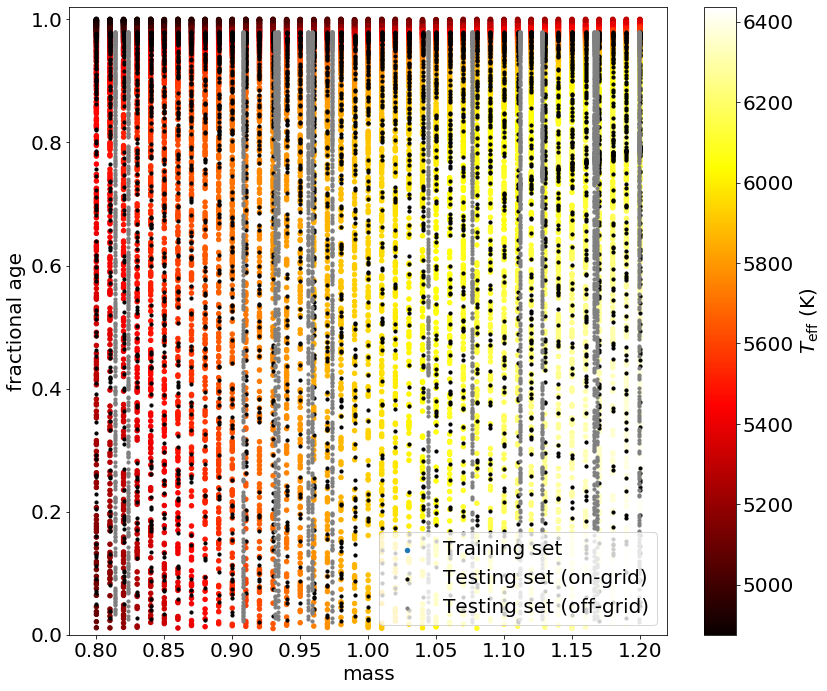

In [8]:
fig, ax1 = plt.subplots(1,1)
cp = ax1.scatter(training_data['initial_mass'], training_data['frac_age'], 
                 c = training_data['effective_T'],s = 20, label = 'Training set', cmap = 'hot') 
ax1.scatter(testing_data1['initial_mass'], testing_data1['frac_age'], 
            c = 'k',s = 10, label = 'Testing set (on-grid)') 
ax1.scatter(testing_data2['initial_mass'], testing_data2['frac_age'], 
            c = 'grey',s = 10, label = 'Testing set (off-grid)') 
ax1.set_xlabel(r'mass')
ax1.set_ylabel(r'fractional age')
ax1.set_xlim([0.78,1.22])
ax1.set_ylim([0.0,1.02])
cc = plt.colorbar(cp)
cc.set_label(r'$T_{\rm eff}$ (K)')
ax1.legend(fontsize = 20)
fig.tight_layout()
#fig.savefig(gmk._savepath + '2d_data_on_HR.pdf')
#ax1.set_title('MESA grid models')

# Step 2 is kernel selection
# We adopted a MLP kernel because it is able to manage multiple-dimesion inputs. However, the MLP kernel may not be able to handle the sharp change around the hook, we hence test  a couple different kernels as follow:

# gpm0 = MLP
# gpm1 = EXP
# gpm2 = MLP + EXP
# gpm3 = MLP * EXP

more info on https://github.com/SheffieldML/GPy

In [11]:
# this function is designed for pandas dataframe

def gp_a_dataframe(df = None, xcolumns = None, ycolumns = None, kname = None):
        
    start_time = time.time()
    
    #convert a dataframe to np array and set up inputs (xx) and outputs (yy).
    
    nx = len(xcolumns)
    ny = len(ycolumns)
    if (nx>1):
        xx = df[xcolumns].to_numpy()
    else:
        xx = df[xcolumns].to_numpy().reshape(-1,1)
        
    if (ny > 1):
        yy = df[ycolumns].to_numpy()
    else:
        yy = df[ycolumns].to_numpy().reshape(-1,1)
        
    # define some kernels here     
    krbf = GPy.kern.RBF(input_dim=nx, variance=1., lengthscale=1., ARD = True)
    kmlp = GPy.kern.MLP(input_dim=nx, ARD = True)
    kexp = GPy.kern.Exponential(input_dim=nx, variance=1., lengthscale=1., ARD = True)
    krq = GPy.kern.RatQuad(input_dim = nx, variance=1.0, lengthscale=None, power=2.0, ARD=True, active_dims=None, name='RatQuad')

    if kname == 'RBF': 
        k = krbf
    elif kname == 'EXP': 
        k = kexp 
    elif kname == 'MLP': 
        k = kmlp
    elif kname == 'RQ': 
        k = krq
    elif kname == 'MLP*EXP':
        k = kmlp*kexp
    elif kname == 'MLP+EXP':
        k = kmlp+kexp
    elif kname == 'MLP*RQ':
        k = kmlp*krq
    elif kname == 'MLP+RQ':
        k = kmlp+krq
    else: 
        k = None
    # create a model
            
    gpm = GPy.models.GPRegression(xx,yy,k)
    
    # start training
    gpm.optimize()
    print("--- %s seconds ---" % (time.time() - start_time))
    return gpm

# we firstly train a GPR model with two inputs and one output to demostrate how Gpy works on finding a smooth function.

In [147]:
# the trainning data contents 10K data points, use 3000 (2 minutes) for testing 
training_data = pd.read_csv(datapath + 'gpm.csv')
print(len(training_data))

training_data = training_data.sample(n = 5000, random_state = 100)
training_data.index = range(len(training_data))
training_data['frac_age'] = 10**training_data['frac_age']

10000


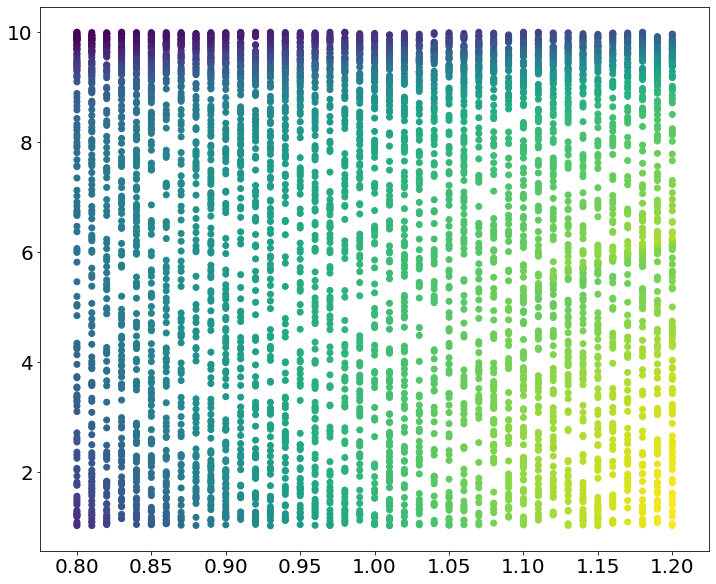

In [13]:
plt.scatter(training_data['initial_mass'], training_data['frac_age'], c = training_data['effective_T'])

In [64]:
testing_data

,Unnamed: 0,evol_stage,initial_mass,initial_Yinit,initial_feh,initial_MLT,star_age,frac_age,ms_age,effective_T,log_g,radius,star_feh,delta_nu_fit,hrgradient,fagegradient,initial_zx,star_zx
0,0,2,1.076546,0.28,0.0,2.1,7.103507,0.984011,5.081790,5388.591356,3.837763,2.067224,-0.019411,47.821950,0.001145,0.000530,0.0181,0.017309
1,1,2,0.955599,0.28,0.0,2.1,11.067167,0.981619,8.624573,5259.741432,3.888722,1.836878,-0.028416,53.727012,0.001197,0.000510,0.0181,0.016954
2,2,1,0.931791,0.28,0.0,2.1,8.247616,0.666974,9.565606,5788.657879,4.332389,1.089957,-0.103229,115.354616,0.000212,0.002156,0.0181,0.014271
3,3,1,0.973372,0.28,0.0,2.1,6.323323,0.600414,7.972049,5887.619017,4.334862,1.110845,-0.098998,114.502466,0.000189,0.002195,0.0181,0.014411
4,4,1,0.823616,0.28,0.0,2.1,3.883866,0.201713,15.741576,5284.905711,4.578112,0.772238,-0.034289,181.084563,0.000213,0.002673,0.0181,0.016726
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4572,4995,1,0.823616,0.28,0.0,2.1,10.528427,0.546806,15.741576,5447.074595,4.471738,0.872847,-0.089259,151.177817,0.000275,0.002788,0.0181,0.014737
4573,4996,1,0.813665,0.28,0.0,2.1,10.857660,0.540147,16.517045,5406.427675,4.480481,0.858869,-0.089426,153.953905,0.000269,0.002695,0.0181,0.014732
4574,4997,1,0.908224,0.28,0.0,2.1,6.627100,0.488293,10.653165,5709.778279,4.437939,0.952954,-0.076359,138.999689,0.000207,0.002606,0.0181,0.015182
4575,4998,1,0.934013,0.28,0.0,2.1,2.842449,0.231869,9.470665,5721.776063,4.507301,0.892217,-0.036864,155.198403,0.000178,0.002799,0.0181,0.016627


In [15]:
# set up xcolumns (inputs) and ycolumns (outputs) for a GPR model
xcolumns = ['initial_mass', 'frac_age']
ycolumns = ['effective_T'] #, 'log_g', 'radius', 'star_feh', 'delta_nu_fit']

# And then
gpm0 = gp_a_dataframe(df = training_data, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP')
gpm1 = gp_a_dataframe(df = training_data, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP*EXP')
gpm2 = gp_a_dataframe(df = training_data, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP+EXP')
gpm3 = gp_a_dataframe(df = training_data, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP+RQ')
gpm4 = gp_a_dataframe(df = training_data, xcolumns = xcolumns, ycolumns = ycolumns, kname = 'MLP*RQ')
# print model for overview

--- 843.9131548404694 seconds ---


 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /opt/anaconda3/lib/python3.7/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


--- 751.9890627861023 seconds ---
--- 1247.2997677326202 seconds ---
--- 1599.206817150116 seconds ---
--- 670.3540921211243 seconds ---


In [106]:
# save the above gpm model with following commands, and then use the other jupyter notebook to load it. 
# both training data and gpm.param_array need to be saved!

#np.save(savepath + 'gpm0.npy', gpm0.param_array)
#training_data.to_csv(savepath + 'gpm0.csv')

# we can plot the GPR model to see how GPR model works, there are several way to inspect the data and model:

plot_data(self, which_data_rows='all', which_data_ycols='all', visible_dims=None, projection='2d', label=None, **plot_kwargs)

plot_data_error(self, which_data_rows='all', which_data_ycols='all', visible_dims=None, projection='2d', label=None, **error_kwargs)

plot(self, plot_limits=None, fixed_inputs=None, resolution=None, plot_raw=False, apply_link=False, which_data_ycols='all', which_data_rows='all', visible_dims=None, levels=20, samples=0, samples_likelihood=0, lower=2.5, upper=97.5, plot_data=True, plot_inducing=True, plot_density=False, predict_kw=None, projection='2d', legend=True, **kwargs)

plot_confidence(self, lower=2.5, upper=97.5, plot_limits=None, fixed_inputs=None, resolution=None, plot_raw=False, apply_link=False, visible_dims=None, which_data_ycols='all', label='gp confidence', predict_kw=None, **kwargs)

plot_density(self, plot_limits=None, fixed_inputs=None, resolution=None, plot_raw=False, apply_link=False, visible_dims=None, which_data_ycols='all', levels=35, label='gp density', predict_kw=None, **kwargs)

plot_f(self, plot_limits=None, fixed_inputs=None, resolution=None, apply_link=False, which_data_ycols='all', which_data_rows='all', visible_dims=None, levels=20, samples=0, lower=2.5, upper=97.5, plot_density=False, plot_data=True, plot_inducing=True, projection='2d', legend=True, predict_kw=None, **kwargs)

plot_mean(self, plot_limits=None, fixed_inputs=None, resolution=None, plot_raw=False, apply_link=False, visible_dims=None, which_data_ycols='all', levels=20, projection='2d', label='gp mean', predict_kw=None, **kwargs)

plot_samples(self, plot_limits=None, fixed_inputs=None, resolution=None, plot_raw=True, apply_link=False, visible_dims=None, which_data_ycols='all', samples=3, projection='2d', label='gp_samples', predict_kw=None, **kwargs)

plot_covariance(kernel, x=None, label=None, plot_limits=None, visible_dims=None, resolution=None, projection='2d', levels=20, **kwargs)

....

More options on 
https://gpy.readthedocs.io/en/deploy/GPy.plotting.gpy_plot.html

 /opt/anaconda3/lib/python3.7/site-packages/GPy/plotting/matplot_dep/plot_definitions.py:184: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


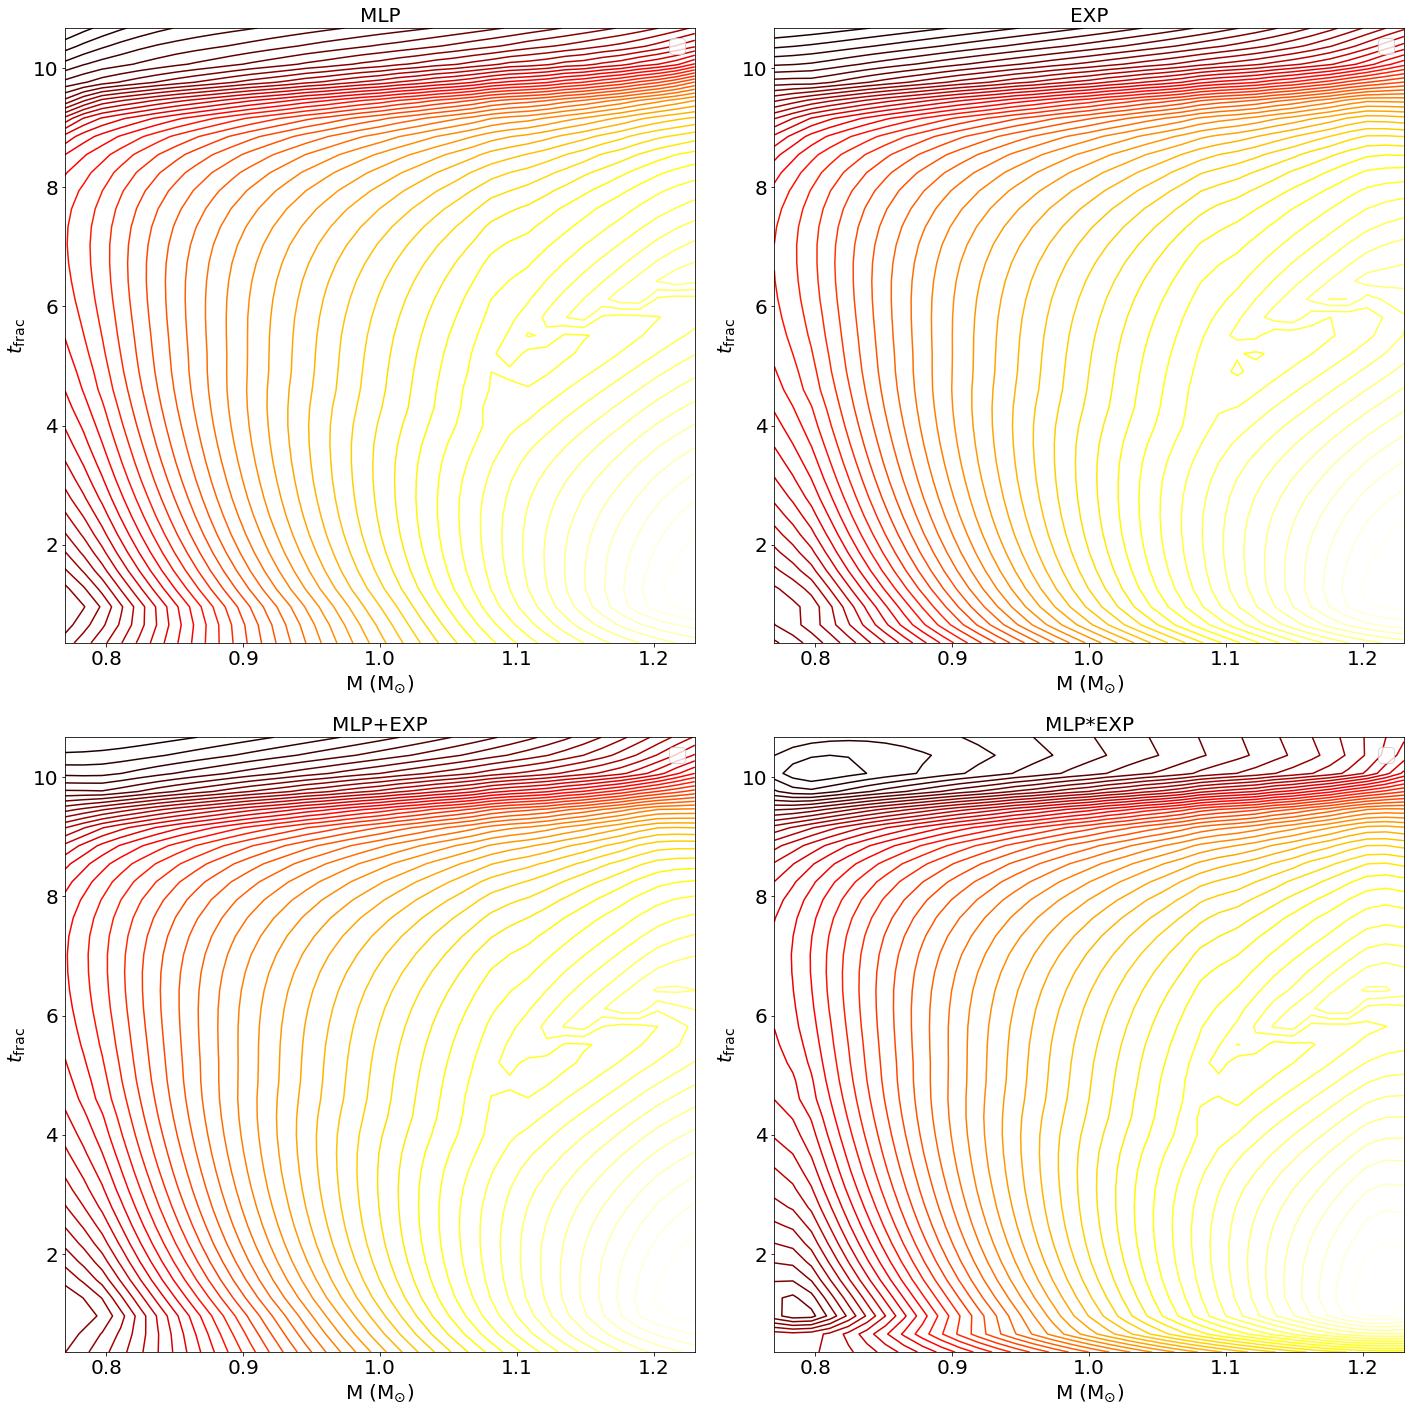

In [17]:
fig, ax = plt.subplots(2,2,figsize = (20,20))
title = [['MLP', 'EXP'], ['MLP+EXP','MLP*EXP']]
gpm = [[gpm0, gpm1], [gpm2, gpm3]]

for i in range(2):
    for j in range(2):
        gpm[i][j].plot(ax = ax[i][j], plot_data = False, levels=50)
        ax[i][j].set_xlabel(r'M (M$_{\odot}$)')
        ax[i][j].set_ylabel(r'$t_{\rm frac}$')
        ax[i][j].set_title(title[i][j])
#colorbar = plt.colorbar(cp)
#colorbar.set_label(r'$T_{\rm eff}$ (K)')
fig.tight_layout()

# Step 3: Validation with the training data, this is to examine wether GPR model well reproduce the training data. This validation decides which kernel is not proper. 

In [30]:
#Here is a function to GP a pandas dataframe
def sample_with_df(n = None, df = None, gpm = None, 
                   xcolumns = None, xshift = None, randomshift = None, 
                   ycolumns = None):
    nx = len(xcolumns)
    ny = len(ycolumns)
        
    df2 = df.copy()
    if (len(df2) < n):
        for i in range(100):
            df2 = pd.concat([df2, df])
            if len(df2)>n: break
        
    df2.index = range(len(df2))
        
    ndf = len(df2)
        
    for name in xcolumns:
        index = xcolumns.index(name)
        if (randomshift == True):
            df2[name] = df2[name] + xshift[index]*(np.random.random(len(df2[name]))-0.5)
        else:
            df2[name] = df2[name] + xshift[index]
        
    if (nx>1):
        xx = df2[xcolumns].to_numpy()
    else:
        xx = df2[xcolumns].to_numpy().reshape(-1,1)
        
    gpp = gpm.predict(xx)
    df2[ycolumns] = gpp[0]
    df2['gp_var'] = gpp[1].reshape(ndf,)
    return df2

In [69]:
ycolumns = ['effective_T']

In [148]:
p0 = sample_with_df(n = 1, df = training_data, gpm = gpm0, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset0 = (training_data[ycolumns] - p0[ycolumns])

p1 = sample_with_df(n = 1, df = training_data, gpm = gpm1, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset1 = (training_data[ycolumns] - p1[ycolumns])

p2 = sample_with_df(n = 1, df = training_data, gpm = gpm2, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset2 = (training_data[ycolumns] - p2[ycolumns])


p3 = sample_with_df(n = 1, df = training_data, gpm = gpm3, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset3 = (training_data[ycolumns] - p3[ycolumns])

p4 = sample_with_df(n = 1, df = training_data, gpm = gpm4, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset4 = (training_data[ycolumns] - p4[ycolumns])

In [89]:
p0 = sample_with_df(n = 1, df = testing_data, gpm = gpm0, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset0x = (testing_data[ycolumns] - p0[ycolumns])

p1 = sample_with_df(n = 1, df = testing_data, gpm = gpm1, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset1x = (testing_data[ycolumns] - p1[ycolumns])


p2 = sample_with_df(n = 1, df = testing_data, gpm = gpm2, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset2x = (testing_data[ycolumns] - p2[ycolumns])


p3 = sample_with_df(n = 1, df = testing_data, gpm = gpm3, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset3x = (testing_data[ycolumns] - p3[ycolumns])

p4 = sample_with_df(n = 1, df = testing_data, gpm = gpm4, 
                    xcolumns = xcolumns, xshift = [0.00,0.00], 
                    randomshift = False, ycolumns = ycolumns)
offset4x = (testing_data[ycolumns] - p4[ycolumns])

0 0 5000
0 1 5000
1 0 5000
1 1 5000


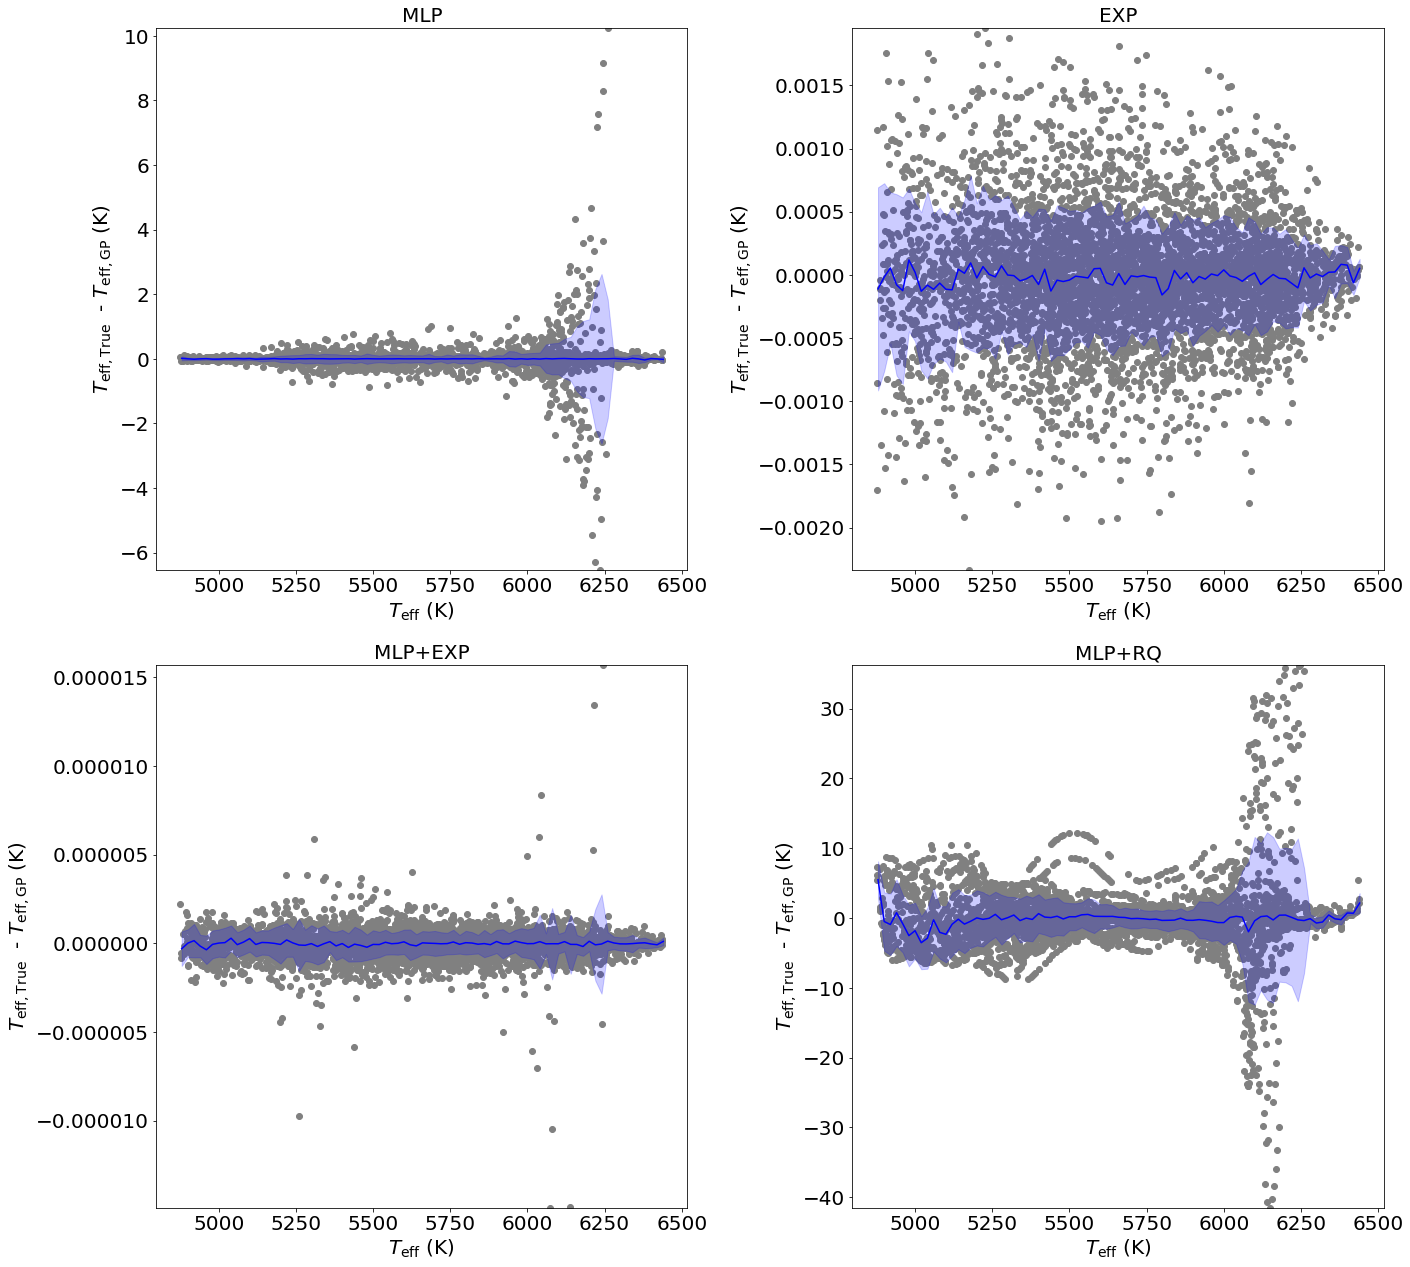

In [179]:
fig, ax = plt.subplots(2,2,figsize = (20,18))
title = [['MLP', 'EXP'], ['MLP+EXP','MLP+RQ']]
offsets = [[offset0, offset1], [offset2, offset4]]
offsetsx = [[offset0x, offset1x], [offset2x, offset4x]]

for i in range(2):
    for j in range(2):
        print(i, j, len(offsets[i][j]))
        ax[i][j].scatter(training_data['effective_T'], offsets[i][j],c = 'grey')
        #ax[i][j].scatter(testing_data['effective_T'], offsetsx[i][j],c = 'r')
        
        x1 =  np.round(training_data['effective_T']/20.0, 0)*20.0

        y1 = offsets[i][j]
        xtd1, ym1, ytd1 = std(x1, y1)
        
        ax[i][j].plot(xtd1, ym1, c = 'b', label = title[i])
        ax[i][j].fill_between(xtd1, (ym1-ytd1), (ym1+ytd1), color='b', alpha=.2)

        ax[i][j].set_xlabel(r'$T_{\rm eff}$ (K)')
        ax[i][j].set_ylabel(r'$T_{\rm eff,True}$  - $T_{\rm eff, GP}$ (K)')
        ax[i][j].set_title(title[i][j])
        ax[i][j].set_ylim([np.min(offsets[i][j]['effective_T']), np.max(offsets[i][j]['effective_T'])])
#colorbar = plt.colorbar(cp)
#colorbar.set_label(r'$T_{\rm eff}$ (K)')
fig.tight_layout()
fig.savefig(savepath + '2d_teff_kernel.pdf')

# Step 4: Validation with the testing data (on-grid and off-grid). This step decides which kernel is the best

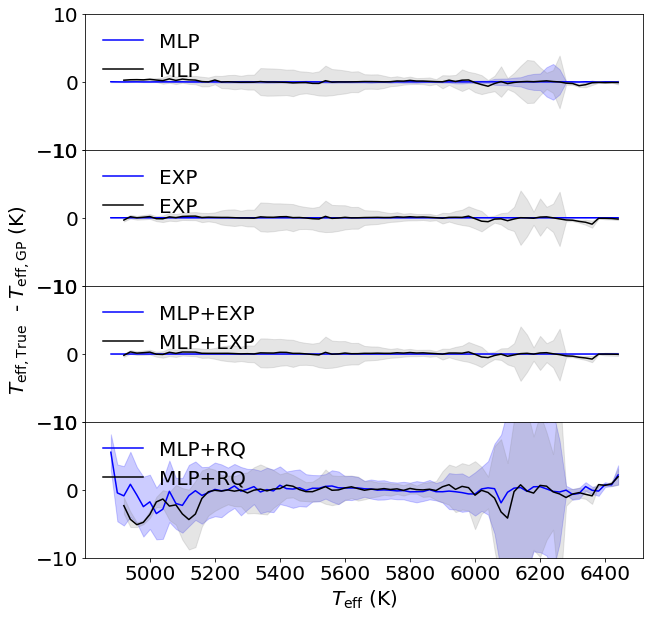

In [182]:
textsize = 20

%matplotlib inline 

params = {'legend.fontsize': textsize,
          'figure.figsize': (12, 10),
         'axes.labelsize': textsize,
         'axes.titlesize':textsize,
         'xtick.labelsize':textsize,
         'ytick.labelsize':textsize,
         'font.size': textsize}
matplotlib.rcParams.update(params)
plt = matplotlib.pyplot


def std(x, y):
    xx = np.unique(x)
    xx = np.sort(xx)
    ymedian = xx*0.0
    ystd = xx*0.0
    for i in range(len(xx)):
        idex = (x == xx[i])
        ymedian[i] = np.median(y[idex])
        ystd[i] = np.std(y[idex])
    return xx, ymedian, ystd

def confidence_interval(x, y, ci):
    xx = np.unique(x)
    xx = np.sort(xx)
    ymean = xx*0.0
    ylow = xx*0.0
    yhigh = xx*0.0
    for i in range(len(xx)):
        idex = (x == xx[i])
        ylow[i], ymean[i], yhigh[i] = np.percentile(y[idex], [(100 - ci)/2.0, 50, (100 -(100 - ci)/2.00)])
    return xx, ymean, ylow, yhigh

fig, ax = plt.subplots(4,1,figsize = (10,10))

title = ['MLP', 'EXP', 'MLP+EXP','MLP+RQ']
offsets = [offset0, offset1, offset2, offset4]
offsetsx = [offset0x, offset1x, offset2x, offset4x]

for i in range(4):
        
        x1 = None
        x2 = None
        x3 = None
        x4 = None
        
        x1 =  np.round(training_data['effective_T']/20.0, 0)*20.0
        x =  np.round(testing_data['effective_T']/20.0, 0)*20.0

        
        y1 = offsets[i]
        y = offsetsx[i]

        
        xtd1, ym1, ytd1 = std(x1, y1)
        xtd2, ym2, ytd2 = std(x, y)
        
        ax[i].plot(xtd1, ym1, c = 'b', label = title[i])
        ax[i].fill_between(xtd1, (ym1-ytd1), (ym1+ytd1), color='b', alpha=.2)

        ax[i].plot(xtd2, ym2, 'k', label = title[i])
        ax[i].fill_between(xtd2, (ym2-ytd2), (ym2+ytd2), color='grey', alpha=.2)
        
        ax[i].set_xlabel(r' ')
        if i !=3: ax[i].set_xticks([])
        if i ==3: ax[i].set_xlabel(r'$T_{\rm eff}$ (K)')
        if i == 2: ax[i].set_ylabel(r'                 $T_{\rm eff,True}$  - $T_{\rm eff, GP}$ (K)')
        #ax[i].set_title(title[i][j])
        ax[i].set_ylim([-10,10]) 
        ax[i].legend(loc = 'upper left', shadow = False, frameon=False)
fig.subplots_adjust(hspace=0)
fig.savefig(savepath + '2d_teff_validataion.pdf')

# Below are some more plots. 

# Now we use the GPR model to predict Teff with on-grid validation data
# And we can compare predictions with true value to estimate on-grid offsets

In [34]:
predictions = sample_with_df(n = len(validation_data1), df = validation_data1, gpm = gpm, 
                                   xcolumns = xcolumns, xshift = [0.00,0.00], 
                                   randomshift = False, ycolumns = ycolumns)

Text(0.5, 0, '(True - GP)/True (%)')

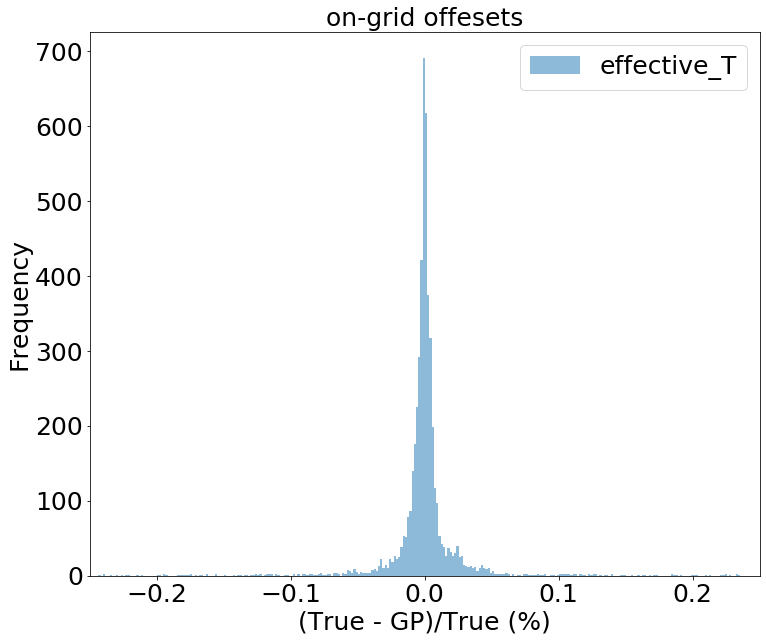

In [40]:
offsets = (validation_data1[ycolumns] - predictions[ycolumns])/validation_data1[ycolumns]*100
ax = offsets.plot.hist(bins=1000, alpha=0.5)
ax.set_title('on-grid offesets')
ax.set_xlim([-0.25,0.25])
ax.set_xlabel('(True - GP)/True (%)')

In [48]:
# with same method, we estimate off-grid offsets

In [49]:
predictions = sample_with_df(n = len(validation_data2), df = validation_data2, gpm = gpm, 
                                   xcolumns = xcolumns, xshift = [0.00,0.00], 
                                   randomshift = False, ycolumns = ycolumns)

Text(0.5, 0, '(True - GP)/True (%)')

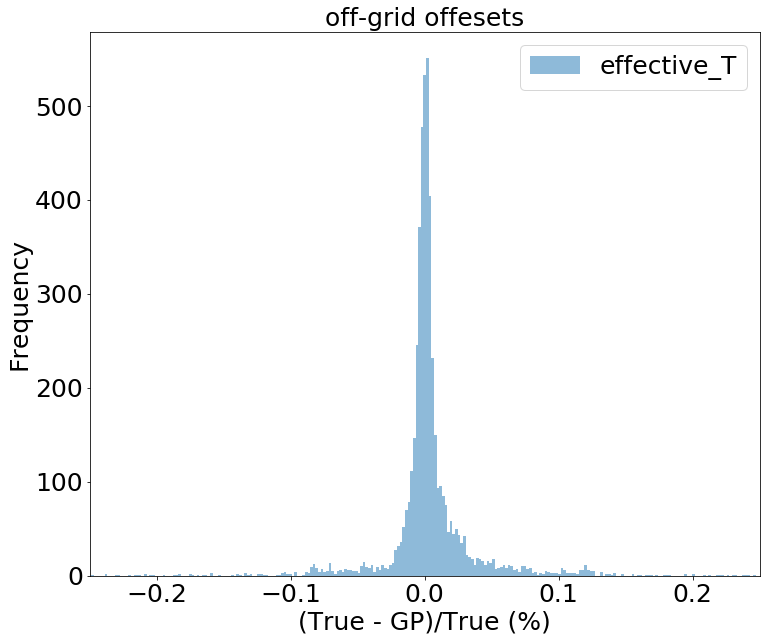

In [50]:
offsets = (validation_data2[ycolumns] - predictions[ycolumns])/validation_data2[ycolumns]*100
ax = offsets.plot.hist(bins=1000, alpha=0.5)
ax.set_title('off-grid offesets')
ax.set_xlim([-0.25,0.25])
ax.set_xlabel('(True - GP)/True (%)')

# A detailed inspection of validation errors is ploting the offsets on mass vs fage diagram. It can be seen that, a small number of points around the hook (mass = 1.15-1.2, fage = 0.8) is not predicted as well as other area.  

Text(0.5, 1.0, 'off-grid offesets for Teff')

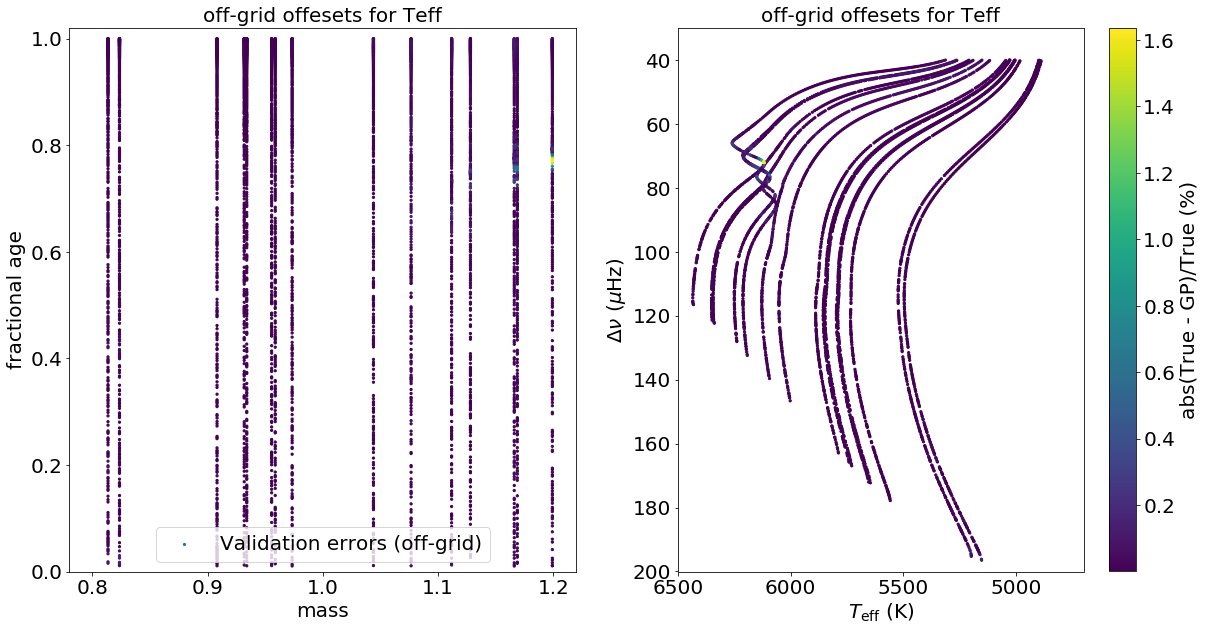

In [74]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
cp = ax1.scatter(validation_data2['initial_mass'], validation_data2['frac_age'], 
                 c = np.abs(offsets['effective_T']),s = 5, label = 'Validation errors (off-grid)') 
ax1.set_xlabel(r'mass')
ax1.set_ylabel(r'fractional age')
ax1.set_xlim([0.78,1.22])
ax1.set_ylim([0.0,1.02])
ax1.legend(fontsize = 20)
#fig.savefig(gmk._savepath + '2d_data_on_HR.pdf')
ax1.set_title('off-grid offesets for Teff')


cp = ax2.scatter(validation_data2['effective_T'], validation_data2['delta_nu_fit'], 
                 c = np.abs(offsets['effective_T']),s = 5, label = 'Validation errors (off-grid)') 
ax2.set_xlabel(r'$T_{\rm eff}$ (K)')
ax2.set_ylabel(r'$\Delta\nu$ ($\mu$Hz)')
ax2.set_xlim([6500,4700])
ax2.set_ylim([200,30])
cc = plt.colorbar(cp)
cc.set_label(r'abs(True - GP)/True (%)')
ax1.set_title('off-grid offesets for Teff')
ax2.set_title('off-grid offesets for Teff')